<a href="https://colab.research.google.com/github/karaage0703/karaage-ai-book/blob/master/ch06/06_karaage_ai_book_tflite_convert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TensorFlow Lite軽量化


## 事前準備

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

2.3.0


In [2]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
import time

テスト画像をダウンロードします。

In [3]:
!wget https://raw.githubusercontent.com/karaage0703/janken_dataset/master/choki/choki_01.jpg

--2020-11-22 14:33:15--  https://raw.githubusercontent.com/karaage0703/janken_dataset/master/choki/choki_01.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27653 (27K) [image/jpeg]
Saving to: ‘choki_01.jpg’

choki_01.jpg        100%[===================>]  27.00K  --.-KB/s    in 0s      

2020-11-22 14:33:16 (123 MB/s) - ‘choki_01.jpg’ saved [27653/27653]



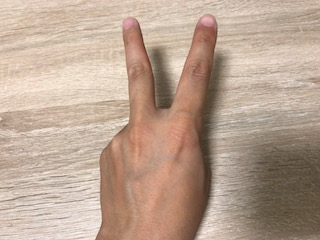

In [4]:
from IPython.display import Image as IPImage
from IPython.display import display_jpeg
display_jpeg(IPImage('choki_01.jpg'))

モデルとラベルをGoogle Driveからコピーします。

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!cp '/content/drive/My Drive/karaage-ai-book/my_model.h5' './my_model.h5'
!cp '/content/drive/My Drive/karaage-ai-book/efficientnet_model.h5' './efficientnet_model.h5'
!cp '/content/drive/My Drive/karaage-ai-book/labels.txt' './labels.txt'

In [7]:
!ls -lh

total 124M
-rw-r--r-- 1 root root  28K Nov 22 14:33 choki_01.jpg
drwx------ 5 root root 4.0K Nov 22 14:33 drive
-rw------- 1 root root  34M Nov 22 14:33 efficientnet_model.h5
-rw------- 1 root root   12 Nov 22 14:33 labels.txt
-rw------- 1 root root  91M Nov 22 14:33 my_model.h5
drwxr-xr-x 1 root root 4.0K Nov 13 17:33 sample_data


ラベルを読み込みます

In [8]:
labels = []
with open('./labels.txt','r') as f:
  for line in f:
    labels.append(line.rstrip())
print(labels)

NUM_CLASSES = len(labels)

['choki', 'gu', 'pa']


## モデルの変換

モデルを読み込みます

MNISTベースの自作モデルを読み込みます。

In [9]:
keras_mnist_model = tf.keras.models.load_model("my_model.h5")

TFLiteモデルに変換します。

In [10]:
converter = tf.lite.TFLiteConverter.from_keras_model(keras_mnist_model)

tflite_model = converter.convert()
open("mnist_model.tflite", "wb").write(tflite_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmpw9dr7w4c/assets


31572588

EfficientNetモデルを読み込みます。

In [11]:
# keras_model = tf.keras.models.load_model("efficientnet_model.h5")

import tensorflow_hub as hub
keras_efficientnet_model = tf.keras.models.load_model('efficientnet_model.h5', custom_objects={'KerasLayer':hub.KerasLayer})

https://github.com/tensorflow/tensorflow/issues/26835

モデルを変換します。

In [12]:
converter = tf.lite.TFLiteConverter.from_keras_model(keras_efficientnet_model)

tflite_model = converter.convert()
open("efficientnet_model.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpx2bx2m0_/assets


INFO:tensorflow:Assets written to: /tmp/tmpx2bx2m0_/assets


16113268

## モデルの性能（推論時間）を比較

### 軽量化前のモデル

データの変換

In [16]:
img = img_to_array(load_img('choki_01.jpg', target_size=(64,64)))
img = img / 255.0
img = img[np.newaxis]
img = np.asarray(img)

MNISTベースモデルの推論

In [26]:
%%time
preds = keras_mnist_model.predict(img)
result = np.argmax(preds[0])
print(labels[result])

choki
CPU times: user 48.4 ms, sys: 0 ns, total: 48.4 ms
Wall time: 51.1 ms


EfficientNetモデルの推論

In [27]:
%%time
preds = keras_efficientnet_model.predict(img)
result = np.argmax(preds[0])
print(labels[result])

choki
CPU times: user 50.1 ms, sys: 6.03 ms, total: 56.2 ms
Wall time: 55.2 ms


### 軽量化したモデル

MNISTモデルのTFLiteファイルを読み込みます。

In [28]:
interpreter = tf.lite.Interpreter(model_path="mnist_model.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [29]:
print(input_details)

[{'name': 'conv2d_2_input', 'index': 0, 'shape': array([ 1, 64, 64,  3], dtype=int32), 'shape_signature': array([-1, 64, 64,  3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [30]:
print(output_details)

[{'name': 'Identity', 'index': 16, 'shape': array([1, 3], dtype=int32), 'shape_signature': array([-1,  3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


データの変換

In [31]:
img = img_to_array(load_img('choki_01.jpg', target_size=(64,64)))
img = img / 255.0
img = img[np.newaxis]
img = np.asarray(img)
input_tensor = tf.convert_to_tensor(img)

推論

In [34]:
%%time
# set input tensor
interpreter.set_tensor(input_details[0]['index'], input_tensor)

# Inference
interpreter.invoke()

scores = interpreter.get_tensor(output_details[0]['index'])
result = np.argmax(scores[0])
print(labels[result])

choki
CPU times: user 10.9 ms, sys: 79 µs, total: 11 ms
Wall time: 11.8 ms


EfficientNetモデルのTFLiteファイルを読み込みます。

In [35]:
interpreter = tf.lite.Interpreter(model_path="efficientnet_model.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

推論

In [37]:
%%time
# set input tensor
interpreter.set_tensor(input_details[0]['index'], input_tensor)

# Inference
interpreter.invoke()

scores = interpreter.get_tensor(output_details[0]['index'])
result = np.argmax(scores[0])
print(labels[result])

choki
CPU times: user 12.6 ms, sys: 0 ns, total: 12.6 ms
Wall time: 10.9 ms


# 参考リンク

- https://qiita.com/iwatake2222/items/d63aa67e5c700fcea70a
- https://qiita.com/PINTO/items/008c54536fca690e0572#4-2-5-tensorflowkeras-h5json-%E3%81%8B%E3%82%89%E3%81%AE%E9%87%8F%E5%AD%90%E5%8C%96